## Introducción a la explicabilidad e interpretabilidad en modelos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_3b_Introduccion_explicabilidad_interpretabilidad.ipynb)

En este notebook encontrarás material introductorio para entender los conceptos de expicabilidad e interpretabilidad en modelos de inteligencia artificial.

Abordaremos el siguiente paso a paso:


*   Cargaremos el dataset load_wine y construiremos una red neuronal para resolver dicho problema.
*   Utilizaremos la técnica SHAP para explicar nuestro modelo.



In [1]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [72]:
#importamos las librerias necesarias a utilizar
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import seaborn as sns
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


%matplotlib inline

## Dataset

El [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset) cuenta con 178 registros, cada uno con 13 caracteristicas:

* Alcohol
* Malic Acid
* Ash
* Alcalinity of Ash
* Magnesium
* Total Phenols
* Flavanoids
* Nonflavanoid Phenols
* Proanthocyanins
* Colour Intensity
* Hue
* OD280/OD315 of diluted wines
* Proline

El dataset contiene 3 clases diferentes: Class_1, Class_2,Class_3

In [18]:
#Cargamos el conjunto de datos y procesamos
wine = load_wine()
X, y = wine.data, wine.target

# dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# convertimos y a one hot encoded vector
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

# escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dimension datos de entrenamiento: ", X_train.shape)
print("Dimension datos de prueba: ", X_test.shape)

Dimension datos de entrenamiento:  (124, 13)
Dimension datos de prueba:  (54, 13)


## Modelo

In [64]:
#Definimos la red neuronal a entrenar y compilamos el modelo
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
#Entrenamos la red
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.4157 - loss: 1.0442 - val_accuracy: 0.7200 - val_loss: 0.8392
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5802 - loss: 0.9172 - val_accuracy: 0.8800 - val_loss: 0.7460
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5664 - loss: 0.9099 - val_accuracy: 0.9600 - val_loss: 0.6597
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7142 - loss: 0.7492 - val_accuracy: 0.9600 - val_loss: 0.5856
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8364 - loss: 0.6740 - val_accuracy: 0.9600 - val_loss: 0.5215
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7955 - loss: 0.6507 - val_accuracy: 0.9600 - val_loss: 0.4634
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8352 - loss: 0.6070 - val_accuracy: 0.9600 - val_loss: 0.4121
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9290 - loss: 0.5245 - val_accuracy: 0.9600 - val_loss: 0.3665

In [66]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Accuracy en el conjunto de prueba: 1.0000


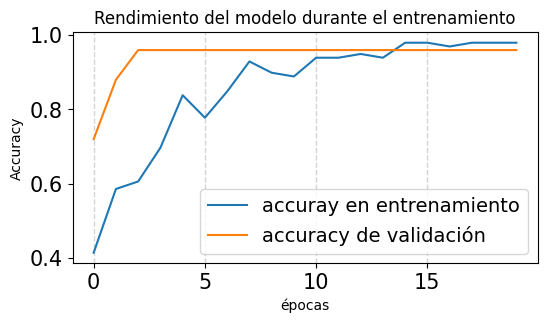

In [67]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='accuray en entrenamiento')
plt.plot(history.history['val_accuracy'], label='accuracy de validación')
plt.xlabel('épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Rendimiento del modelo durante el entrenamiento')
plt.grid()
plt.show()

Ya tenemos un MLP o red densa que nos predice la clase del vino bastante bien. Sin embargo, lo que no está muy claro es cómo cada una de estas características contribuye a la probabilidad de clase de vino predicha. Podemos pensar en estas explicaciones en términos **globales** (es decir, ¿cómo impacta cada característica en los resultados en promedio para todo los datos?) o en términos **locales** (es decir, ¿cómo impacta cada característica en las predicciones para una muestra en específico?).

Algunos modelos tienen propiedades incorporadas que proporcionan este tipo de explicaciones. Estos se conocen típicamente como modelos de **caja blanca (white-box)** y los ejemplos incluyen la regresión lineal (coeficientes del modelo), la regresión logística (coeficientes del modelo) y los árboles de decisión (importancia de las características). Debido a su complejidad, otros modelos, como las Máquinas de Vectores de Soporte (SVM) y las Redes Neuronales (incluyendo nuestro Perceptrón Multicapa) etc., no tienen métodos directos para explicar sus predicciones. Para estos modelos (también conocidos como modelos de **caja negra (black-box)**), se pueden aplicar enfoques como **LIME** y **SHAP**.

## LIME para datos tabulares

Local Interpretable Model-agnostic Explanation ([**LIME**](https://arxiv.org/abs/1602.04938)) proporciona un método rápido y relativamente simple para explicar localmente modelos de caja negra. El algoritmo LIME se puede simplificar en unos pocos pasos:

1. Para un punto de datos dado, perturba aleatoriamente sus características repetidamente. Para datos tabulares, esto implica agregar una pequeña cantidad de ruido a cada característica.

2. Obtén predicciones para cada instancia de datos perturbada. Esto nos ayuda a construir una imagen local de la superficie de decisión en ese punto.

3. Usa las predicciones para calcular un "modelo de explicación" lineal aproximado utilizando las predicciones. Los coeficientes del modelo lineal se utilizan como explicaciones.

La librería de Python LIME proporciona interfaces para explicar modelos construidos sobre datos tabulares (TabularExplainer), imágenes (LimeImageExplainer) y texto (LimeTextExplainer).

En la siguiente sección, intentaremos explicar las predicciones de una única instancia de datos de prueba utilizando LimeTabularExplainer

In [68]:
data_df = pd.DataFrame(X_train,
                      columns=wine.feature_names)

lime_explainer = LimeTabularExplainer(training_data=data_df.values,
                                      feature_names=list(data_df.columns),
                                      class_names = ['Class_1', 'Class_2', 'Class_3'],
                                      # básicamente no tenemos datos
                                      # categóricos
                                      categorical_features=[],
                                      mode="classification")

In [108]:
index = 9
explanation = lime_explainer.explain_instance(X_test[index],
                                              model.predict,
                                              num_features=len(wine.feature_names),
                                              top_labels=2)

print(f"Explicación para la muestra con índice: {index} con clase verdadera: class_{np.argmax(y_test[index])+1}")
explanation.show_in_notebook(show_table=True, show_all=True,)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Explicación para la muestra con índice: 9 con clase verdadera: class_3


**NOTA:** Esta nota es para recordar que el rendimiento de este algoritmo no es plenamente confiable ya que se basa en que tanto el modelo lineal que LIME crea pueda explicar el modelo NO LINEAL original. Así que, las capacidades de explicabilidad y confianza son limitadas. En la vida real, habrá que explorar crear mejores aproximaciones. Sin embargo seguirá siendo una limitante grande.

Para tratar con este problema, es posible hacer uso de algunos atributos de LIME:

```
explanation.intercept
explanation.local_pred
explanation.local_exp
explanation.score
explanation.top_labels
```

In [117]:
help(LimeTabularExplainer)

Help on class LimeTabularExplainer in module lime.lime_tabular:

class LimeTabularExplainer(builtins.object)
 |  LimeTabularExplainer(training_data, mode='classification', training_labels=None, feature_names=None, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=None, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)
 |  
 |  Explains predictions on tabular (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, training

Esta idea de aplicar perturbaciones y generar explicaciones locales, ha sido extendida a texto e imágenes:

[LIME para texto:](https://https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html)
[LIME para Imágenes](https://https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html)

## SHAP para datos tabulares

[Sitio oficial](https://shap.readthedocs.io/en/latest/)

Imagina esta situación: Tenemos a tres brillantes científicos de datos (llamémoslos Ana, Luis y Sofía) trabajando juntos en un proyecto para la empresa. Al final del año, su increíble modelo predictivo ha generado un aumento de ganancias de 5 millones de euros. Ahora, la pregunta es: ¿cómo repartimos estos 5 millones de manera justa entre Ana, Luis y Sofía, de acuerdo con la contribución real de cada uno al éxito del modelo?

SHAP (SHapley Additive exPlanations) nos da una manera de hacer precisamente esto, pero en lugar de científicos de datos y ganancias, piensa en las características de tus datos y la predicción de tu modelo.

**La Idea Central: El Valor de Shapley**

La base de SHAP son los llamados "valores de Shapley". Estos valores vienen de un área de las matemáticas que estudia cómo repartir justamente las ganancias en juegos de colaboración entre varios jugadores. SHAP toma esta idea y la aplica a las características de tu modelo.

**¿Cómo se calcula este "valor justo" para cada característica?**

Imagina que vamos añadiendo las características a nuestro modelo una por una, en todos los órdenes posibles, y observamos cuánto cambia la predicción en cada paso.

Por ejemplo, imágina en un servicio de subscripción por cable y pensemos en predecir si un cliente va a abandonar el servicio de cable, basándonos en tres características: su antigüedad, sus cargos mensuales y si tiene fibra óptica.

Primero, podríamos usar solo la antigüedad para hacer una predicción (aunque probablemente no sería muy buena). Anotamos esta predicción.
Luego, añadimos los cargos mensuales a la antigüedad y vemos cómo cambia la predicción. La diferencia entre la nueva predicción y la anterior sería la "contribución marginal" de los cargos mensuales en este orden específico.
Finalmente, añadimos si tiene fibra óptica a las dos anteriores y vemos el cambio en la predicción. Esa sería la contribución marginal de la fibra óptica en este orden.
Pero, ¡el orden importa! Podríamos haber empezado añadiendo la fibra óptica primero, luego la antigüedad y después los cargos mensuales, y la "contribución" de cada característica en cada paso podría ser diferente.

**El Truco de SHAP: Promediar Todas las Posibilidades**

Para obtener el valor de Shapley de una característica, SHAP hace precisamente esto: calcula la contribución marginal promedio de esa característica en ¡todos los posibles órdenes en los que podríamos haber añadido las características al modelo!

**Aplicando esto al Aprendizaje Automático:**

En el contexto de tu modelo de Deep Learning (como tu Perceptrón Multicapa), SHAP trata cada característica de tus datos como si fuera uno de nuestros científicos de datos, y la predicción del modelo como si fueran las ganancias.

Para entender cómo contribuye cada característica a una predicción específica, SHAP calcula el valor de Shapley para cada característica de esa instancia. Un valor de Shapley positivo para una característica significa que ese valor de la característica empujó la predicción del modelo hacia un resultado particular (por ejemplo, una mayor probabilidad de abandono). Un valor de Shapley negativo significa que empujó la predicción en la dirección opuesta. Algo parecido a LIME.

**¿Por qué SHAP es especial? Dos Garantías Importantes:**

SHAP tiene dos propiedades muy importantes que lo hacen destacar frente a otras formas de explicar modelos (como LIME o la importancia de las características basada en la permutación):

Precisión Local: La suma de los valores de Shapley de todas las características para una predicción específica, más un valor base (la predicción promedio del modelo), debe ser igual a la predicción real del modelo para esa instancia. Esto significa que la explicación local es *consistente con la salida del modelo original*.

**Consistencia**: Si cambias tu modelo de tal manera que una característica tenga un mayor impacto en la predicción en todos los posibles órdenes en los que se podría añadir, entonces su valor de Shapley (su "crédito") nunca debería disminuir. Esto asegura que las explicaciones sean intuitivas y coherentes con los cambios en el modelo.

**En la Práctica: Simulando la Eliminación de Características**

Una dificultad práctica es cómo simular la "eliminación" de una característica al calcular su contribución marginal en un modelo ya entrenado. No podemos simplemente quitar una columna de datos y esperar que el modelo siga funcionando.

La librería SHAP utiliza una técnica inteligente para abordar esto. Simula la ausencia de una característica reemplazándola con los valores que esa característica toma en un "conjunto de datos de fondo" (background dataset). Este conjunto de datos de fondo representa la distribución "típica" de las características.

En resumen, SHAP te da una manera justa y consistente de entender la contribución de cada característica a la predicción de tu modelo para una instancia específica, basándose en la idea de cómo se repartirían las ganancias en un juego colaborativo. Te dice cuánto "responsable" es cada característica del resultado final de la predicción.



In [132]:
#Computemos los valores SHAP de nuestro modelo
explainer = shap.Explainer(model, X_train,feature_names=wine.feature_names)
shap_values = explainer(X_test)

- Por ejemplo. Para nuestro modelo, la caracteristica que mas aporta para que se prediga de la clase 1, es **proline**, y  la que menos aporta es **malic_acid**.

**Pero atención! Esto ya es a nivel de Clase no de explicación de una muestra.**

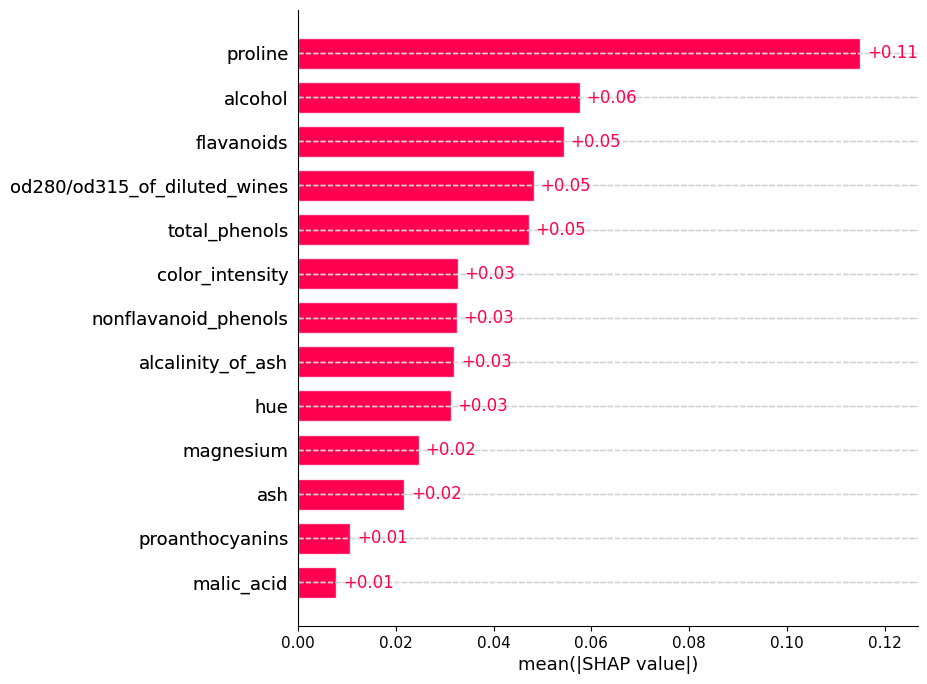

In [137]:
shap.plots.bar(shap_values[:,:,0], max_display=X_test.shape[1])

* Para la clase 2, la caracteristica que mas aporta es **alcohol/proline** y la que menos aporta a dicha predicción es **proanthocyanins**.


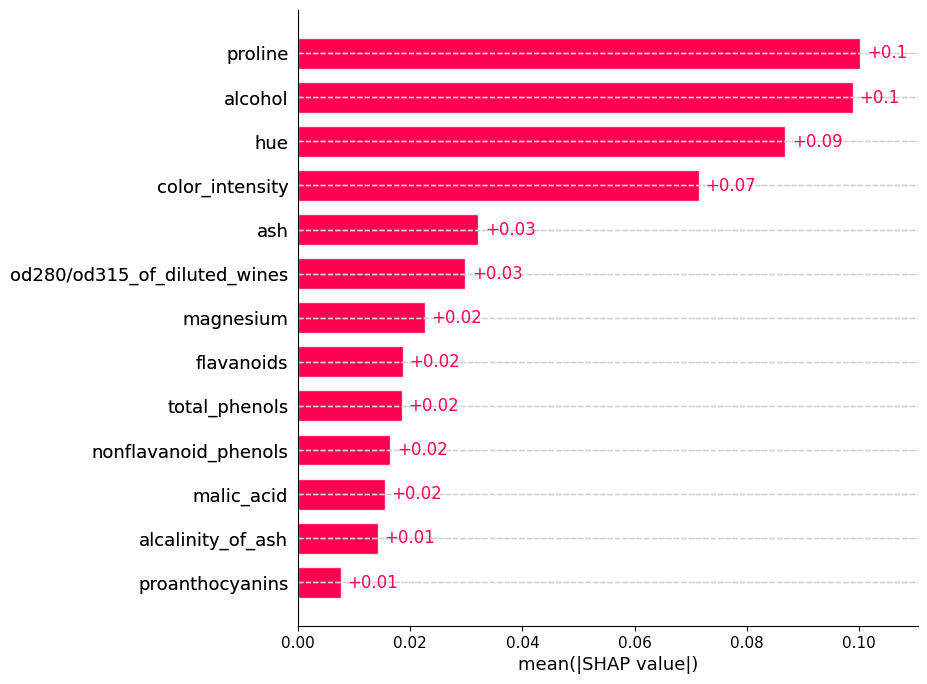

In [134]:
shap.plots.bar(shap_values[:,:,1], max_display=X_test.shape[1])

* Para la tercera clase, la caracteristica mas importante es **diluted wines** y la menos importante es **magnesium**

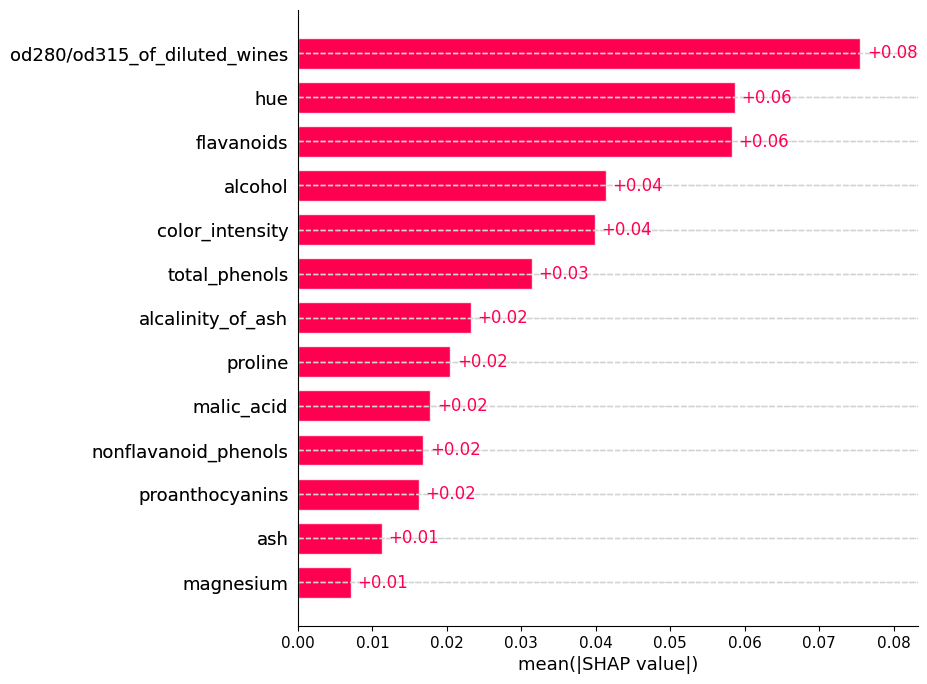

In [135]:
shap.plots.bar(shap_values[:,:,2], max_display=X_test.shape[1])

Para ver estas contribuciones podemos verlo en un gráfico conjunto para un subconjunto de datos.

<ipython-input-142-480fe46790a7>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=wine.feature_names,


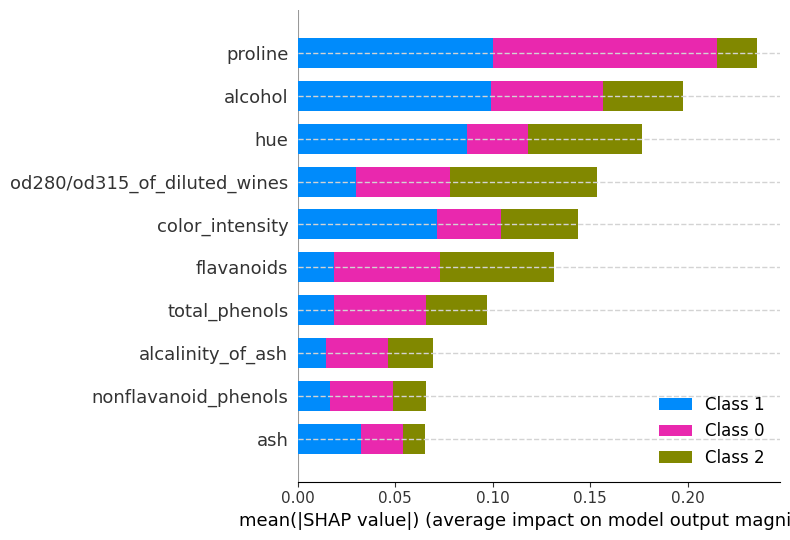

In [142]:
shap.initjs()
shap.summary_plot(shap_values, X_test, feature_names=wine.feature_names,
                  max_display=10);

* Tambien podriamos ver para cada clase como aporta cada caracteristica a la predicción del modelo.

clase 1


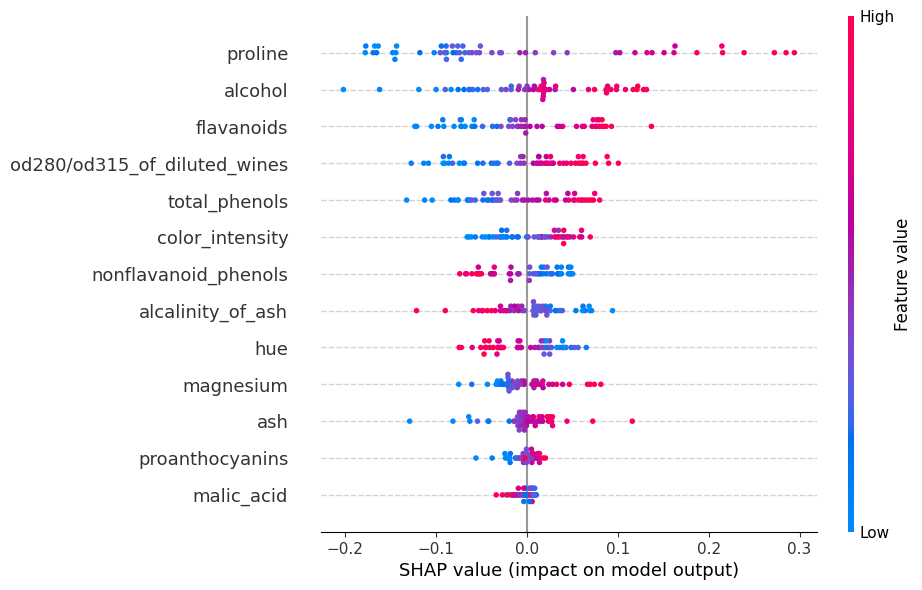

In [143]:
print("clase 1")
shap.plots.beeswarm(shap_values[:,:,0], max_display=X_test.shape[1])

clase 2


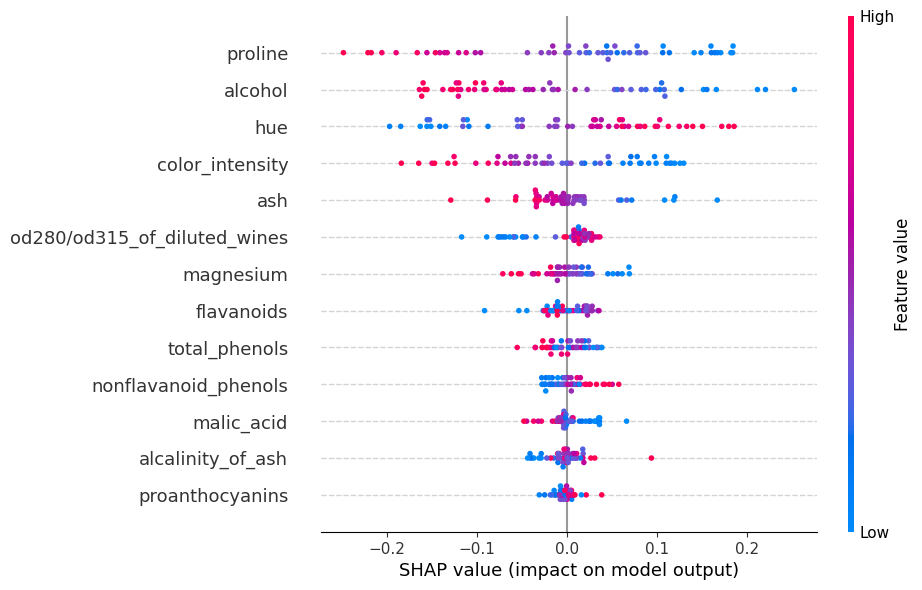

In [144]:
print("clase 2")
shap.plots.beeswarm(shap_values[:,:,1], max_display=X_test.shape[1])

clase 3


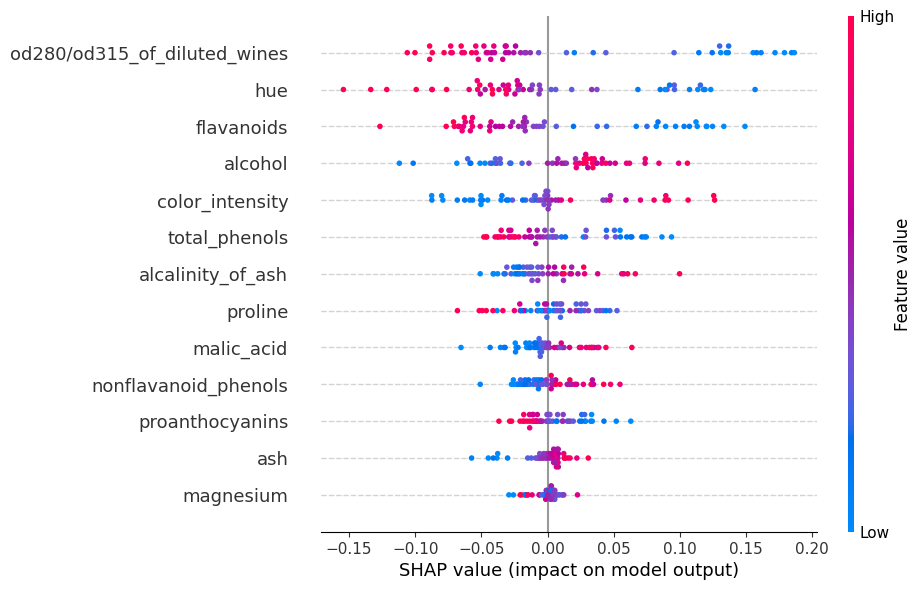

In [145]:
print("clase 3")
shap.plots.beeswarm(shap_values[:,:,2], max_display=X_test.shape[1])


**Ahora si explicaciones más locales por muestra:**

* Ahora tomemos un dato de test y veamos como las caracteristicas influyeron para que la red se inclinara por la categoría cierta.

clase:  [0. 0. 1.]


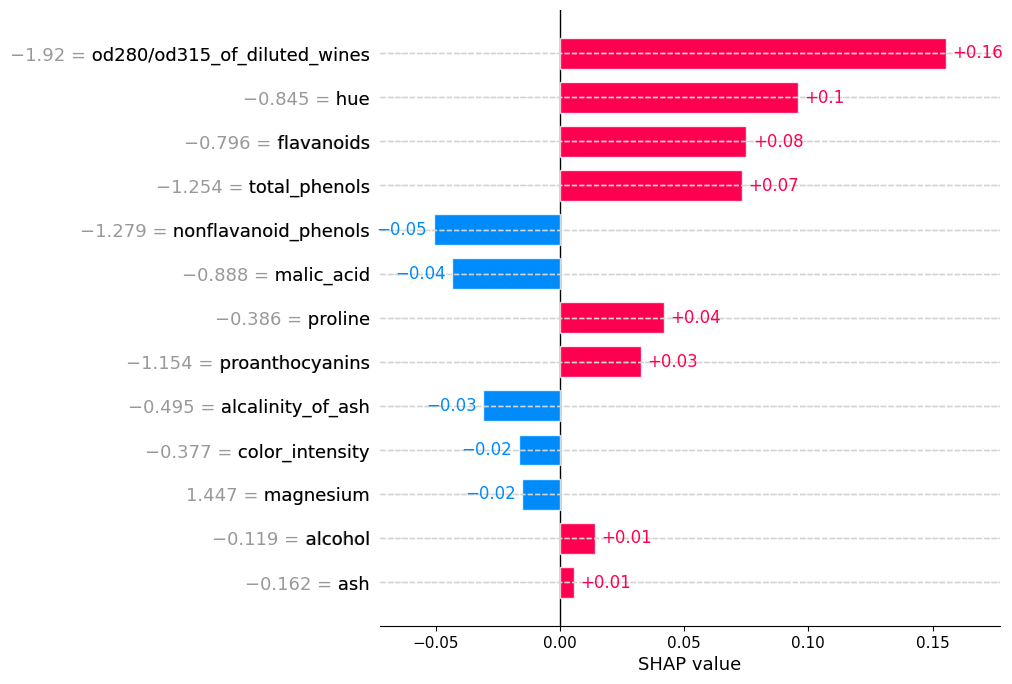

In [138]:
clase = y_test[9]
print("clase: ", clase)
shap.plots.bar(shap_values[9,:,np.argmax(clase)], max_display=X_test.shape[1])

SHAP ha sido adaptado para otros dominios y problemas:

[Imágenes](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Front%20Page%20DeepExplainer%20MNIST%20Example.html)

[Texto](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html)

## Conclusión: LIME vs. SHAP: ¿Cuándo usar cuál?


Tanto LIME como SHAP son buenos métodos para explicar los modelos de aprendizaje automático.

En teoría, SHAP es el mejor enfoque porque ofrece garantías matemáticas sobre la precisión y consistencia de sus explicaciones. Esto significa que podemos confiar más en que las explicaciones de SHAP reflejan fielmente cómo funciona el modelo.

A continuación, mencionamos algunas limitaciones adicionales de ambos métodos:

**Limitaciones de LIME:**

* No está diseñado para datos con "one-hot encoding": El "one-hot encoding" es cuando transformamos variables categóricas (como "color" con valores "rojo", "azul", "verde") en varias columnas binarias (una para "color_rojo", otra para "color_azul", etc.). LIME funciona creando pequeñas variaciones (perturbaciones) de tus datos para ver cómo cambia la predicción. Si perturbas una variable "one-hot encoded", podrías terminar con combinaciones sin sentido (por ejemplo, que una observación sea "rojo" y "azul" al mismo tiempo, o que no sea ningún color), lo que llevaría a explicaciones poco fiables. (Puedes ver una discusión sobre esto aquí).

* Depende de cómo "perturbas" los datos: LIME necesita alterar las muestras de datos de forma que tenga sentido para tu caso específico.
Para datos tabulares, esto suele implicar añadir un poco de "ruido" aleatorio a cada característica.
Para imágenes, podría significar reemplazar pequeñas regiones de la imagen (superpíxeles) con un color promedio o con ceros.
Para texto, podría ser quitar palabras del texto. Es importante pensar si estas formas de perturbar tus datos podrían tener efectos secundarios no deseados que afecten la confianza en las explicaciones.
* El modelo local de LIME podría no ser un buen reflejo del modelo original: LIME crea un modelo local más simple para explicar una predicción específica. A veces, este modelo local puede no capturar bien el comportamiento del modelo original complejo. Es una buena práctica verificar si hay inconsistencias antes de confiar plenamente en las explicaciones de LIME.
* Funciona mejor con modelos que dan probabilidades: LIME está pensado para modelos de clasificación que predicen la probabilidad de cada clase (por ejemplo, "70% de probabilidad de ser clase A"). Algunos modelos, como las Máquinas de Vectores de Soporte (SVMs), no están diseñados naturalmente para dar probabilidades (aunque se les puede forzar, a veces con problemas). Usar LIME con las "pseudo-probabilidades" de estos modelos podría introducir algún sesgo en las explicaciones.

**Limitaciones de SHAP**:

* Depende de un "conjunto de datos de fondo" (background dataset): SHAP necesita un conjunto de datos de referencia para calcular un valor base o esperado de la predicción. Si tu conjunto de datos es muy grande, usarlo todo para este cálculo puede ser muy costoso computacionalmente (llevaría mucho tiempo). Por eso, a menudo se usan aproximaciones, como tomar una muestra más pequeña del conjunto de datos. Esto podría afectar un poco la precisión de la explicación.

* Explica la desviación respecto a un valor base estimado del entrenamiento: SHAP te dice cómo la predicción de una instancia se desvía del valor promedio que el modelo aprendió con todo el conjunto de datos de entrenamiento. Sin embargo, dependiendo de tu objetivo, podría ser más útil comparar la predicción con un grupo más específico.
Ejemplo: Si estás prediciendo la "fuga de clientes" (churn), quizás te interese más explicar por qué un cliente se va a ir en comparación con los clientes que no se fueron, en lugar de compararlo con el promedio de todos los clientes (incluyendo los que se fueron y los que no). En este caso, querrías usar el conjunto de datos de los clientes que no se fueron como tu "conjunto de datos de fondo".



